# Advanced Lane Finding

## 1. Introduction
The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

#### 1.1 Notebook Settings

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

#### 1.2 Imports 

In [2]:
import copy
import pickle
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 2. Camera Calibration

Before I can create the main pipeline the camera must first be calibrated. This is performed using a calibration function that takes a list of chessboard calibration images, and returns a calibration dictionary containing the camera matrix and distribution coefficients. This is then tested for a sample of the callibration images.

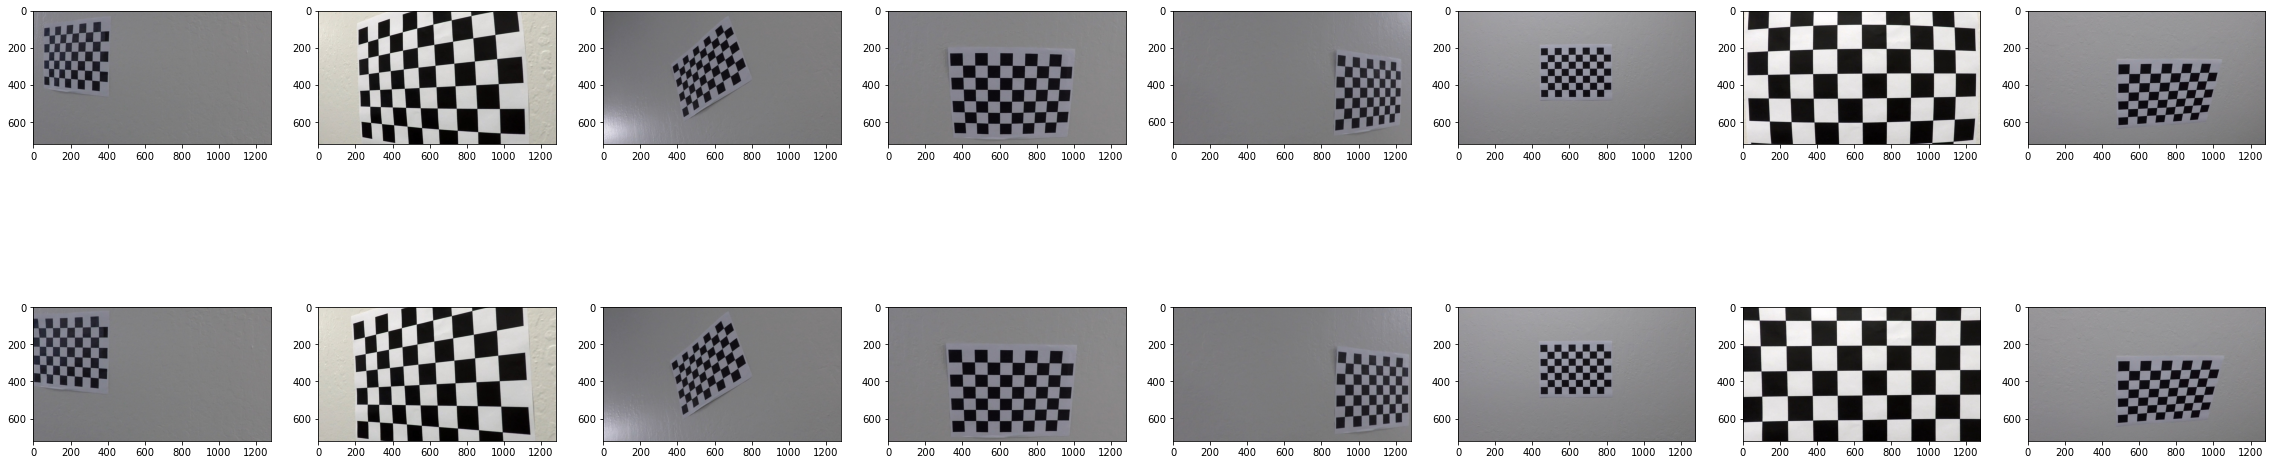

In [3]:
# Camera calibration
def calibrate_camera(chess_images, size=(8, 6)):
    """Function to calibrate a camera using a set of images taken of a 6*8 chessboard at various angles.

    Parameters:
        chess_images (list) :  List of strings containing location of all training image files.
        size (tuple) : X by Y size of chessboard. (Default = (8, 6))
    Returns:
        cal (dict) : Returns calibration dictionary containing the camera matrix ['mtx'] and distortion parameters ['dist'].
    """

    # Define the 'true' chessboard points in 3D space
    objp = np.zeros((size[1] * size[0], 3), np.float32)
    objp[:, :2] = np.mgrid[0 : size[0], 0 : size[1]].T.reshape(-1, 2)
    objpoints = []

    # Find the corresponding locations of the corresponding points observed in 2D space for each image
    imgpoints = []
    for idx, fname in enumerate(chess_images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (size[0], size[1]), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Use these 'true' and 'observed' points to calibrate the camera and return the calibration object
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None
    )
    cal = {}
    cal["mtx"] = mtx
    cal["dist"] = dist
    return cal


# Example of use
cal = calibrate_camera(glob.glob("camera_cal/calibration*.jpg"), size=(9, 6))
test_image_files = glob.glob("test_images/test*.jpg") + glob.glob(
    "test_images/straight_lines*.jpg"
)
cal_test_files = glob.glob("camera_cal/calibration*.jpg")[0:8]
cal_tests = []
cal_undsts = []
for ctf in cal_test_files:
    cal_test = cv2.imread(ctf)
    cal_test = cv2.cvtColor(cal_test, cv2.COLOR_BGR2RGB)
    image_size = (cal_test.shape[1], cal_test.shape[0])
    undst = cv2.undistort(cal_test, cal["mtx"], cal["dist"], None, cal["mtx"])
    cal_tests.append(cal_test)
    cal_undsts.append(undst)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(cal_test_files))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(cal_tests[j])
        if i == 1:
            a.imshow(cal_undsts[j])
plt.savefig("output_images/cal_test.pdf")

## 3. Pipeline (Test Images)

Here I summaraise all the lane finding pipeline:
1. Distortion Correction
2. Perspective Transform
3. Gradient Thresholding
4. Color Space Thresholding
5. Histogram Peaks
6. Sliding Windows
7. Fit to the Lane Pixels
8. Search from Last Frame
9. Measuring Position and Curvature
10. Visualise the Result

Each of these are implemented in a function below, and tested on the test images. These pipeline steps will then be plugged into the final image processing pipeline that will inject the video stream frame by frame.

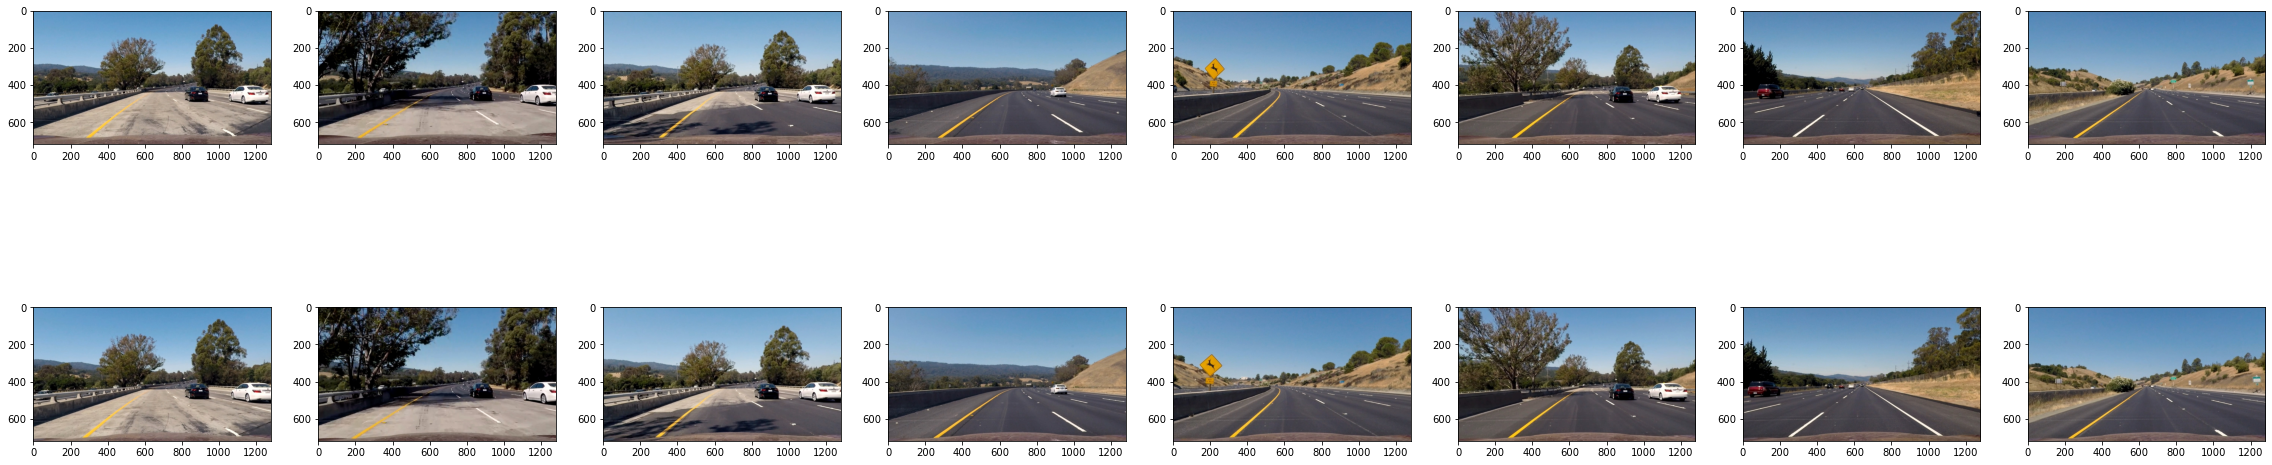

In [4]:
# 1. Distortion correction
def distortion_correction(cal, image):
    """Function to correct camera induced distortion in an image.

    Parameters:
        cal (dict) : Calibration dictionary.
        image (np.array) : Image to be corrected.
    Returns:
        undst ( np.array) : Undistorted image.
    """
    image_size = (image.shape[1], image.shape[0])
    undst = cv2.undistort(image, cal["mtx"], cal["dist"], None, cal["mtx"])
    return undst


# Example of use
test_image_files = glob.glob("test_images/test*.jpg") + glob.glob(
    "test_images/straight_lines*.jpg"
)
test_images = []
undsts = []
for tif in test_image_files:
    test_image = cv2.imread(tif)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    undst = distortion_correction(cal, test_image)
    test_images.append(test_image)
    undsts.append(undst)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(test_images[j])
        if i == 1:
            a.imshow(undsts[j])
plt.savefig("output_images/fig1.pdf")

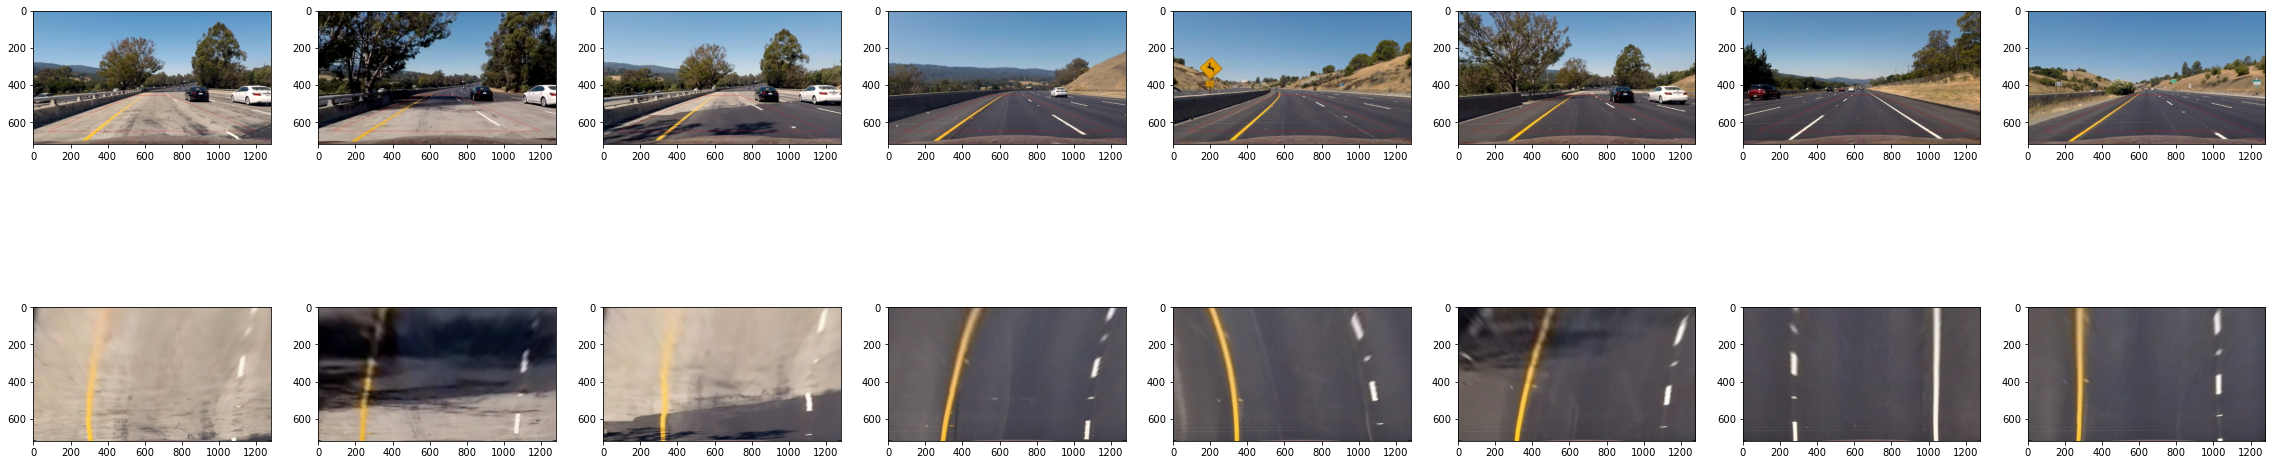

In [5]:
# 2. Perspective transform
def perspective_transform(image, source, destination):
    """Function to change the perspective on an image, mapping the source points to the destination points.

    Parameters:
        image (np.array) : Image to be corrected.
        source (np.array) : 2*N numpy array of N source points in 2D space.
        destination (np.array) : 2*N numpy array of N destination points in 2D space.
    Returns:
        warped (np.array) : Warped image.
        M (np.array) : Warping matrix.
        Minv (np.array) : Inverse of warping matrix.
    """
    image = copy.deepcopy(image)
    image_size = (image.shape[1], image.shape[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    M = cv2.getPerspectiveTransform(source, destination)
    Minv = cv2.getPerspectiveTransform(destination, source)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# Example of use
image_size = (undsts[7].shape[1], undsts[7].shape[0])
source = np.float32([[80, 650], [540, 460], [740, 460], [1200, 650]])
destination = np.float32([[20, 700], [20, 20], [1260, 20], [1260, 700]])
warpeds = []
draws = []
for u in undsts:
    warped, M, Minv = perspective_transform(u, source, destination)
    draw = cv2.polylines(
        copy.deepcopy(u), [np.int32(source).reshape((-1, 1, 2))], True, (255, 0, 0)
    )
    draws.append(draw)
    warpeds.append(warped)

# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(draws[j])
        if i == 1:
            a.imshow(warpeds[j])
plt.savefig("output_images/fig2.pdf")

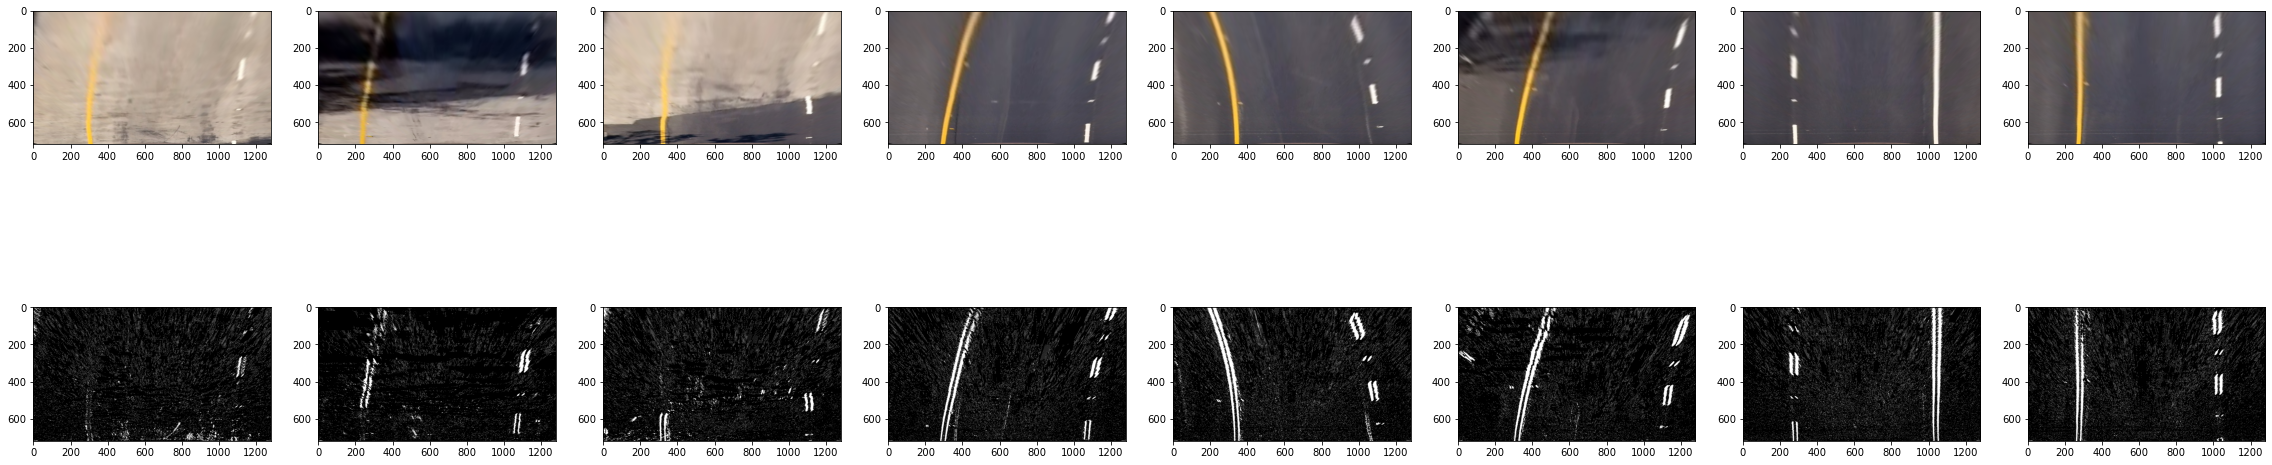

In [6]:
# 3. Gradient thresholding
def gradient_thresholding(image, orient="x", sobel_kernel=3, thresh=(0, 255)):
    """Function to return a binary image based on various gradient thresholds.

    x -> x_grad
    y -> y_grad
    mag -> sqrt(x_grad**2 + x_grad**2)
    dir -> arctan(|y_grad|, |x_grad|)

    Parameters:
        image (np.array) : Image to be thresholded.
        orient (string) : String to indicate which type of gradient theshold to use. 'x', 'y', 'mag' or 'dir'. (default = 'x')
        sobel_kernel (np.array) : Size of kernal used in sobel gradient. (default = 3)
        thresh (tuple) : Thresholds when performing thesholding. (default = (0, 255))
    Returns:
        binary_output (np.array) : Binary image of pixels that passed the threshold.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    elif orient == "mag":
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    elif orient == "dir":
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    else:
        raise ValueError(
            "Invalid orient {}. Expected 'x', 'y', 'mag' or 'dir'.".format(orient)
        )
    if orient != "dir":
        abs_sobel = np.absolute(sobel)
        sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel > thresh[0]) & (sobel <= thresh[1])] = 1
    return binary_output


# Example of use
grad_threshs = []
for w in warpeds:
    gradx = gradient_thresholding(w, orient="x", sobel_kernel=3, thresh=(20, 255))
    grady = gradient_thresholding(w, orient="y", sobel_kernel=3, thresh=(250, 255))
    mag = gradient_thresholding(w, orient="mag", sobel_kernel=3, thresh=(250, 255))
    dirr = gradient_thresholding(w, orient="dir", sobel_kernel=3, thresh=(0.2, 0.4))
    grad_thresh = np.zeros_like(dirr)
    grad_thresh[(gradx == 1) | (grady == 1) | (mag == 1) | (dirr == 1)] = 1
    # grad_thresh = dirr
    grad_threshs.append(grad_thresh)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(warpeds[j])
        if i == 1:
            a.imshow(grad_threshs[j], cmap="gray")
plt.savefig("output_images/fig3.pdf")

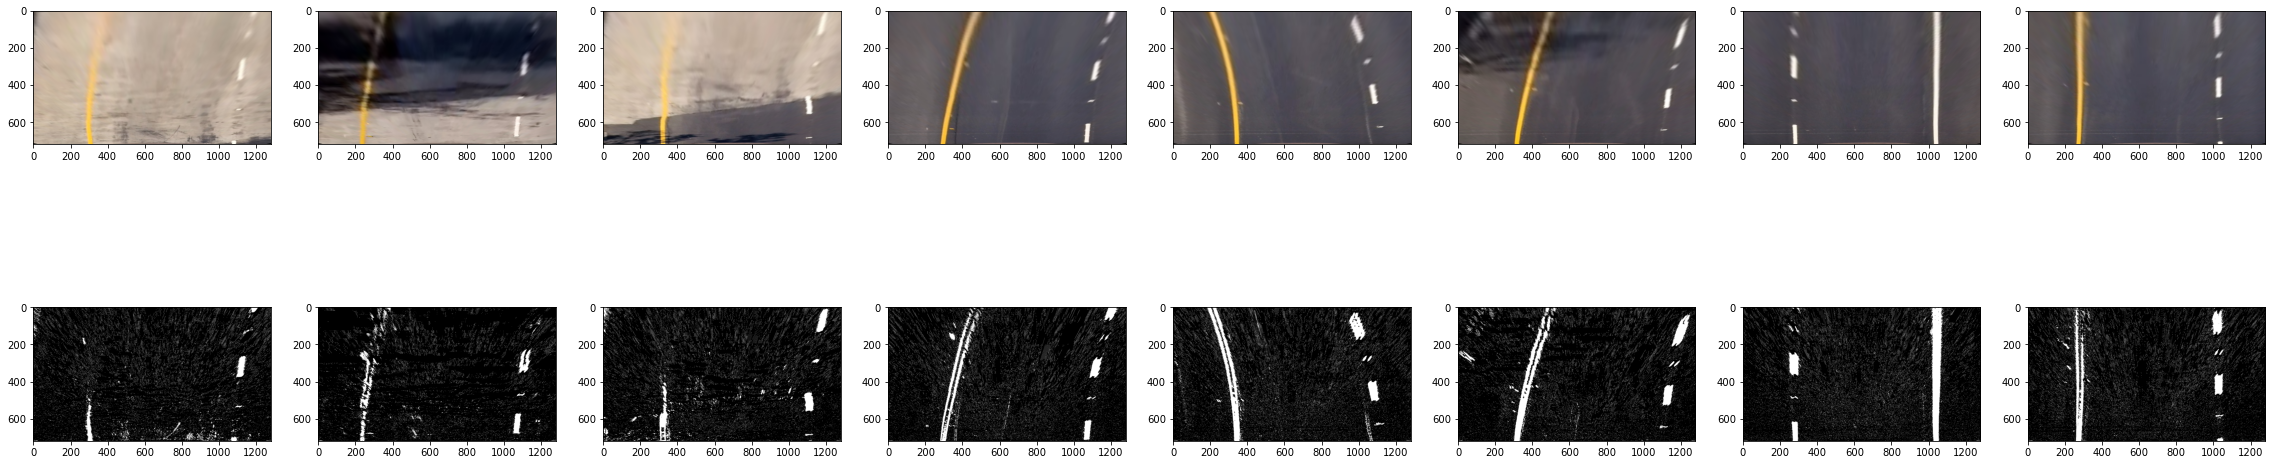

In [7]:
# 4. Color space thresholding
def color_thresholding(image, channel=2, thresh=(0, 255)):
    """Function to return a binary image based on various color thresholds.

    channel 0 -> Hue
    channel 1 -> Level
    channel 2 -> Saturation

    Parameters:
        image (np.array) : Image to be thresholded.
        channel (string) : Int to indicate which channel to use. 0, 1 or 2. (default = 2)
        thresh (tuple) : Thresholds when performing thesholding. (default = (0, 255))
    Returns:
        binary_output (np.array) : Binary image of pixels that passed the threshold.
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    channel_slice = hls[:, :, channel]
    binary_output = np.zeros_like(channel_slice)
    binary_output[(channel_slice > thresh[0]) & (channel_slice <= thresh[1])] = 1
    return binary_output


# Example of use
color_threshs = []
for i, w in enumerate(warpeds):
    color0 = color_thresholding(w, channel=0, thresh=(20, 100))
    color1 = color_thresholding(w, channel=1, thresh=(210, 255))
    color2 = color_thresholding(w, channel=2, thresh=(0, 1))
    color_thresh = np.zeros_like(color0)
    color_thresh[
        (grad_threshs[i] == 1) | (color0 == 1) | (color1 == 1) | (color2 == 1)
    ] = 1
    # color_thresh = color2
    color_threshs.append(color_thresh)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(warpeds[j])
        if i == 1:
            a.imshow(color_threshs[j], cmap="gray")
plt.savefig("output_images/fig4.pdf")

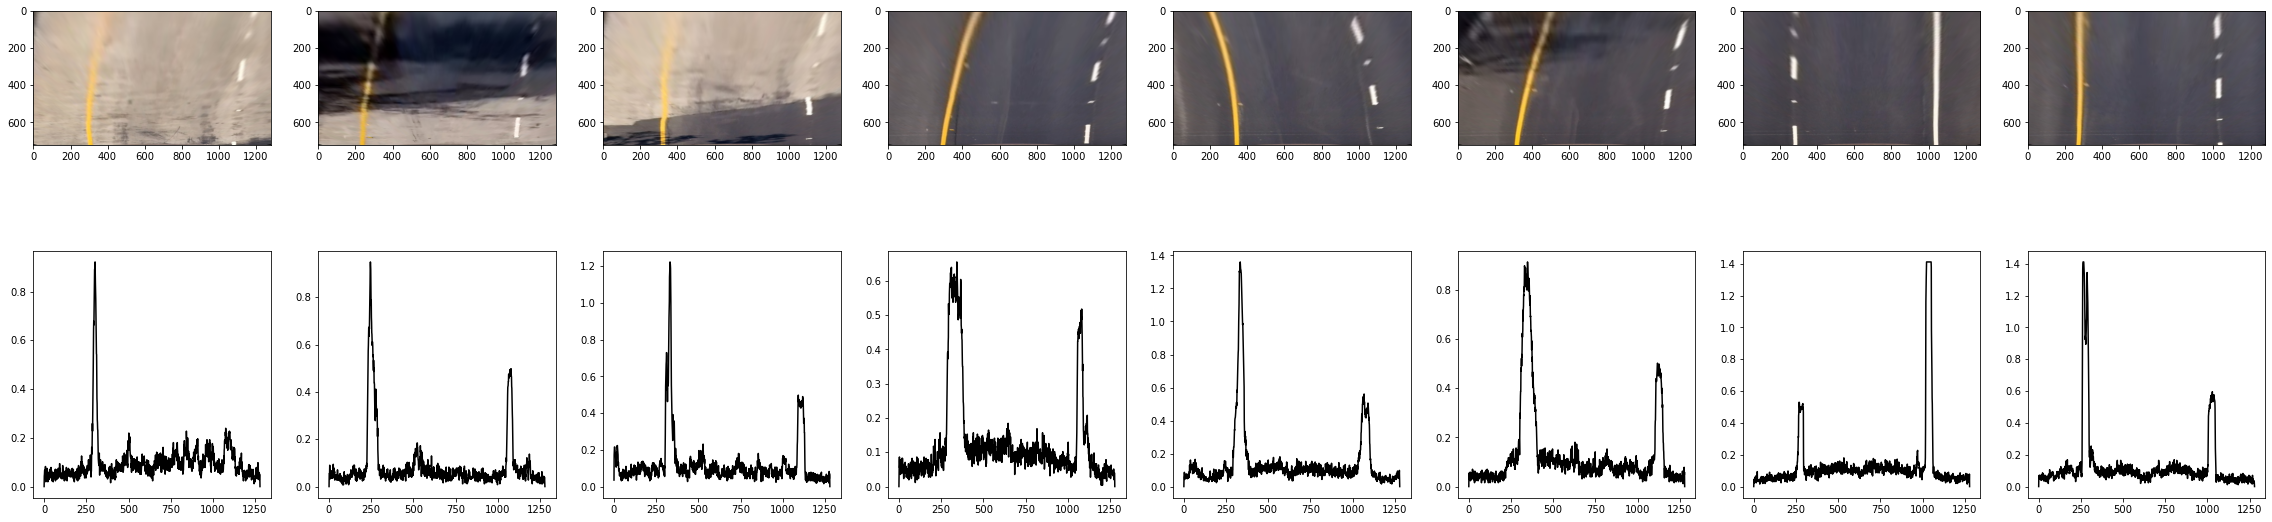

In [8]:
# 5. Histogram peaks
def hist(binary_warped):
    """Function to return histogram representation of a binary image.

    Parameters:
        binary_warped (np.array) : Input image.
    Returns:
        histogram (np.array) : Histogram.
    """
    bottom = binary_warped[binary_warped.shape[0] // 2 :, :]
    histogram = np.sum(bottom, axis=0)
    return histogram


# Example of use
hists = []
for ct in color_threshs:
    histogram = hist(ct / 255)
    hists.append(histogram)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(warpeds[j])
        if i == 1:
            a.plot(hists[j], "k-")
plt.savefig("output_images/fig5.pdf")

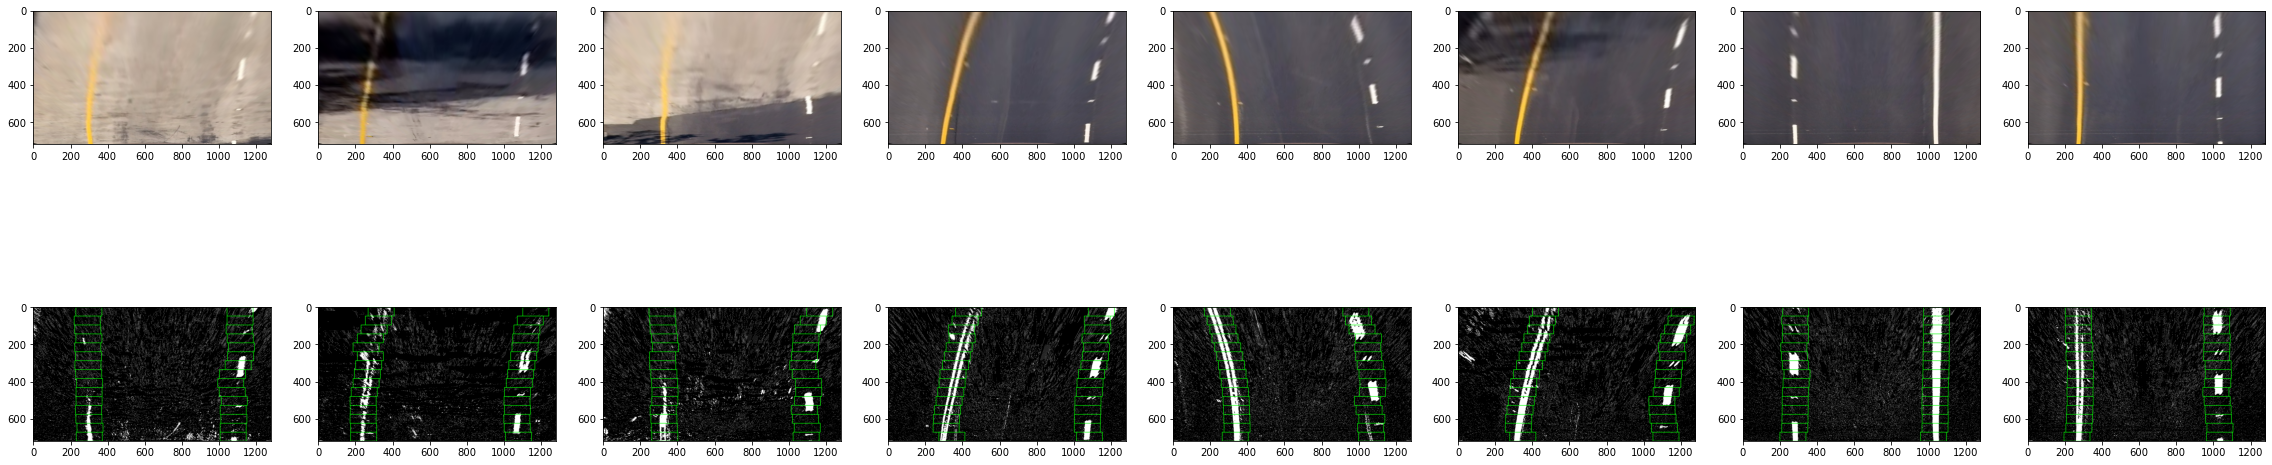

In [9]:
# 6. Sliding windows
def find_lane_pixels(binary_warped, nwindows=9, margin=70, minpix=50):
    """Function to find lane line pixels using the sliding window method.

    Parameters:
        binary_warped (np.array) : Input image.
        nwindows (int) : The number of sliding windows. (default = 9)
        margin (int) : The width of the windows +/- margin. (default = 100)
        minpix (int) : The minimum number of pixels found to recenter window. (default = 50)
    Returns:
        leftx (np.array) : x values of the left lane pixels.
        lefty (np.array) : y values of the left lane pixels.
        rightx (np.array) : x values of the right lane pixels.
        righty (np.array) : y values of the right lane pixels.
        out_image (np.array) : Output Image
    """

    # Create histogram
    histogram = hist(binary_warped / 255)

    # Create image to draw results
    out_img = np.dstack((binary_warped * 255, binary_warped * 255, binary_warped * 255))

    # Find the left and right peaks of the histogram
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2,
        )
        cv2.rectangle(
            out_img,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2,
        )

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


# Example of use
slides = []
slide_outs = []
for ct in color_threshs:
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        ct, nwindows=15, margin=70, minpix=20
    )
    slides.append((leftx, lefty, rightx, righty))
    slide_outs.append(out_img)


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(warpeds[j])
        if i == 1:
            a.imshow(slide_outs[j])
plt.savefig("output_images/fig6.pdf")

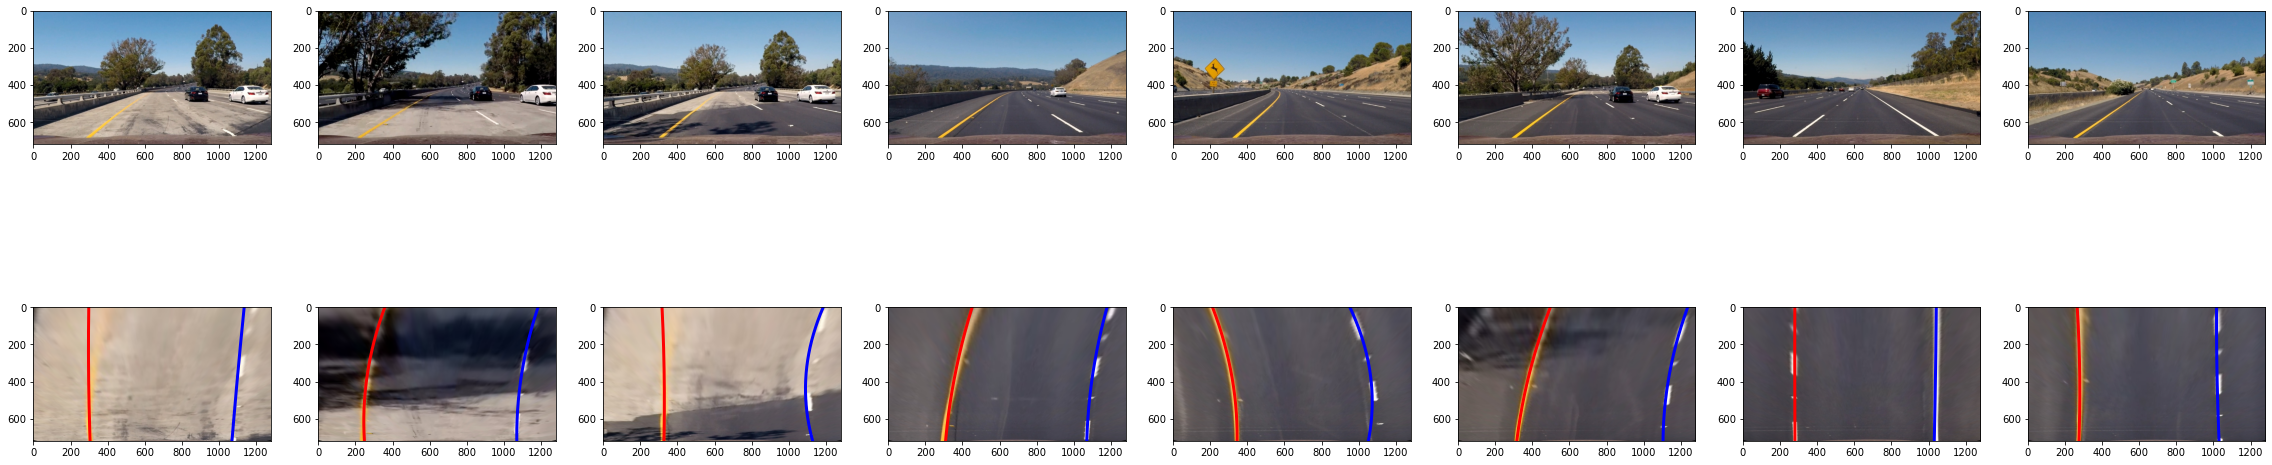

In [10]:
# 7. Fit to lane pixels
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    """Function to fit a second order polynomial to each of the left and right lane line pixels.

    Parameters:
        binary_warped (np.array) : Input image.
        leftx (np.array) : x values of the left lane pixels.
        lefty (np.array) : y values of the left lane pixels.
        rightx (np.array) : x values of the right lane pixels.
        righty (np.array) : y values of the right lane pixels.
    Returns:
        left_fit (np.array) : parameters of the fit of the left lane.
        right_fit (np.array) : parameters of the fit of the right lane.
        left_fitx (np.array) : x values of the left lane fit.
        right_fitx (np.array) : x values of the left lane fit.
        ploty (np.array) : y values of both fits.
    """

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        print("The function failed to fit a line!")
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    # Return all fits
    return left_fit, right_fit, left_fitx, right_fitx, ploty


# Example of use
fits = []
for i, ct in enumerate(color_threshs):
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(ct, *slides[i])
    fits.append((left_fit, right_fit, left_fitx, right_fitx, ploty))


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(test_images[j], cmap="gray")
        if i == 1:
            a.imshow(warpeds[j], cmap="gray")
            a.plot(fits[j][2], fits[j][4], "r-", linewidth=3)
            a.plot(fits[j][3], fits[j][4], "b-", linewidth=3)
plt.savefig("output_images/fig7.pdf")

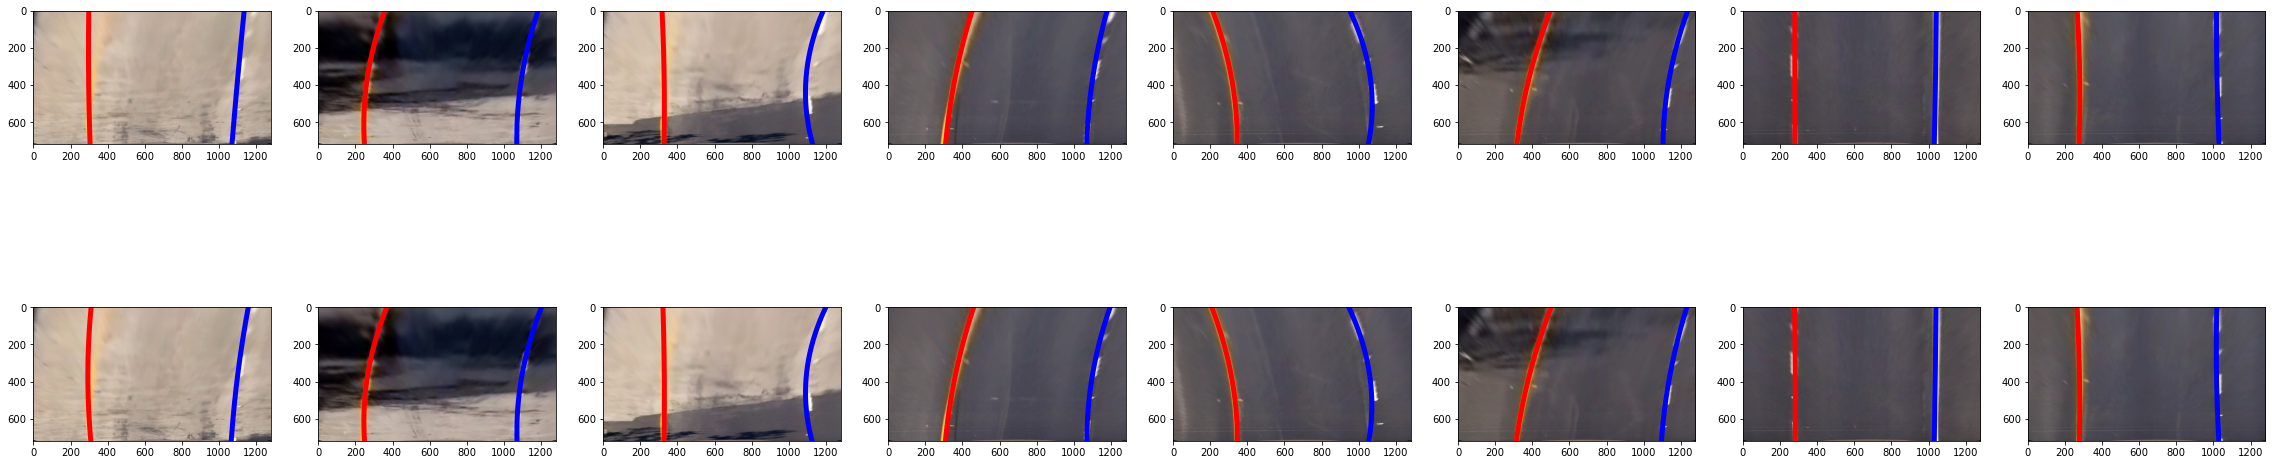

In [11]:
# 8. Search from Last Frame
def search_around_last_frame(binary_warped, left_fit, right_fit, margin=100):
    """Function to fit a second order polynomial to each of the left and right lane line pixels.

    Parameters:
        binary_warped (np.array) : Input image.
        leftx (np.array) : x values of the left lane pixels.
        lefty (np.array) : y values of the left lane pixels.
        rightx (np.array) : x values of the right lane pixels.
        righty (np.array) : y values of the right lane pixels.
    Returns:
        left_fit (np.array) : parameters of the fit of the left lane.
        right_fit (np.array) : parameters of the fit of the right lane.
        left_fitx (np.array) : x values of the left lane fit.
        right_fitx (np.array) : x values of the left lane fit.
        ploty (np.array) : y values of both fits.
    """

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the area of search based on activated x-values
    left_lane_inds = (
        nonzerox
        > (
            left_fit[0] * (nonzeroy ** 2)
            + left_fit[1] * nonzeroy
            + left_fit[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            left_fit[0] * (nonzeroy ** 2)
            + left_fit[1] * nonzeroy
            + left_fit[2]
            + margin
        )
    )
    right_lane_inds = (
        nonzerox
        > (
            right_fit[0] * (nonzeroy ** 2)
            + right_fit[1] * nonzeroy
            + right_fit[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            right_fit[0] * (nonzeroy ** 2)
            + right_fit[1] * nonzeroy
            + right_fit[2]
            + margin
        )
    )

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(
        binary_warped, leftx, lefty, rightx, righty
    )
    return left_fit, right_fit, left_fitx, right_fitx, ploty


# Example of use
fit_news = []
for i, ct in enumerate(color_threshs):
    left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_last_frame(
        ct, fits[i][0], fits[i][1]
    )
    fit_news.append((left_fit, right_fit, left_fitx, right_fitx, ploty))


# Plot example
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(test_images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.imshow(warpeds[j], cmap="gray")
            a.plot(fits[j][2], fits[j][4], "r-", linewidth=5)
            a.plot(fits[j][3], fits[j][4], "b-", linewidth=5)
        if i == 1:
            a.imshow(warpeds[j], cmap="gray")
            a.plot(fit_news[j][2], fit_news[j][4], "r-", linewidth=5)
            a.plot(fit_news[j][3], fit_news[j][4], "b-", linewidth=5)
plt.savefig("output_images/fig7.pdf")

In [12]:
# 9. Measuring position and curvature
def measure_position_curvature(binary_warped, left_fit, right_fit, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720
    xm_per_pix = 3.7 / 700

    # Calculation of position
    bottom = binary_warped[binary_warped.shape[0] // 8 :, :]
    histogram = np.sum(bottom, axis=0)
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    left_position = abs(leftx_base - midpoint) * xm_per_pix
    right_position = abs(rightx_base - midpoint) * xm_per_pix

    # Calculation of radius of curvature
    y_eval = np.max(ploty)
    left_curverad = (
        (1 + (2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1]) ** 2) ** 1.5
    ) / np.absolute(2 * left_fit[0])
    right_curverad = (
        (1 + (2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1]) ** 2) ** 1.5
    ) / np.absolute(2 * right_fit[0])
    return left_position, right_position, left_curverad, right_curverad


# Example of use
pos_curves = []
for i, ct in enumerate(color_threshs):
    (
        left_position,
        right_position,
        left_curverad,
        right_curverad,
    ) = measure_position_curvature(ct, fits[i][0], fits[i][1], fits[i][4])
    print(
        "left position = {0}, right position = {1}, left curvature = {2}, right curvature = {3}".format(
            left_position, right_position, left_curverad, right_curverad
        )
    )

left position = 1.791857142857143, right position = 2.584714285714286, left curvature = 14533.467052546866, right curvature = 36515.65411450137
left position = 2.087857142857143, right position = 2.3204285714285717, left curvature = 1984.7537068682595, right curvature = 2400.15470635208
left position = 1.6227142857142858, right position = 2.5265714285714287, left curvature = 10246.138858708058, right curvature = 1271.9403570672557
left position = 1.4482857142857144, right position = 2.3204285714285717, left curvature = 3735.0454787789236, right curvature = 3205.2321172688607
left position = 1.643857142857143, right position = 2.251714285714286, left curvature = 2196.6150417804906, right curvature = 1410.864281060604
left position = 1.6280000000000001, right position = 2.6270000000000002, left curvature = 3364.839784317909, right curvature = 2401.391501502381
left position = 1.8658571428571429, right position = 2.029714285714286, left curvature = 76004.4174665434, right curvature = 4939

## 3. Pipeline (Project Video)

Now I will merge all of the above into a pipeline that can process video streams.

In [13]:
def draw_lanes(image, cal):
    """Function to annotate lane lines to a given image.

    Using all steps of pipeline above.

    Parameters:
        image (np.array) : Input image.
        cal (dict) : Camera calibration dictionary.
    Returns:
        image (np.array) : Output annotaed image.
    """

    # Applying each stange of the pipline in turn
    undst = distortion_correction(cal, image)
    source = np.float32([[80, 650], [540, 460], [740, 460], [1200, 650]])
    destination = np.float32([[20, 700], [20, 20], [1260, 20], [1260, 700]])
    warped, M, Minv = perspective_transform(undst, source, destination)
    gradx = gradient_thresholding(warped, orient="x", sobel_kernel=3, thresh=(20, 255))
    grady = gradient_thresholding(warped, orient="y", sobel_kernel=3, thresh=(250, 255))
    mag = gradient_thresholding(warped, orient="mag", sobel_kernel=3, thresh=(250, 255))
    dirr = gradient_thresholding(
        warped, orient="dir", sobel_kernel=3, thresh=(0.2, 0.4)
    )
    grad_thresh = np.zeros_like(dirr)
    grad_thresh[(gradx == 1) | (grady == 1) | (mag == 1) | (dirr == 1)] = 1
    color0 = color_thresholding(warped, channel=0, thresh=(20, 100))
    color1 = color_thresholding(warped, channel=1, thresh=(210, 255))
    color2 = color_thresholding(warped, channel=2, thresh=(140, 255))
    color_thresh = np.zeros_like(color0)
    color_thresh[(grad_thresh == 1) | (color0 == 1) | (color1 == 1) | (color2 == 1)] = 1
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        color_thresh, nwindows=15, margin=70, minpix=20
    )
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(
        color_thresh, leftx, lefty, rightx, righty
    )
    (
        left_position,
        right_position,
        left_curverad,
        right_curverad,
    ) = measure_position_curvature(color_thresh, left_fit, right_fit, ploty)

    # Draw the region of lanes identified onto the undistorted image and return
    warp_zero = np.zeros_like(color_thresh).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    fits = (left_fit, right_fit)
    return result, fits

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


cal = calibrate_camera(glob.glob("camera_cal/calibration*.jpg"), size=(9, 6))


def process_image(image):
    global fits_list, frame
    frame += 1
    result, fits = draw_lanes(image, cal)
    fits_list.append(fits)
    return result


fits_list = []
frame = -1


output = "project_video_output_outliers.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

t:   0%|          | 2/1260 [00:00<01:23, 15.02it/s, now=None]

Moviepy - Building video project_video_output_outliers.mp4.
Moviepy - Writing video project_video_output_outliers.mp4



Moviepy - Done !
Moviepy - video ready project_video_output_outliers.mp4
CPU times: user 7min 24s, sys: 1min 13s, total: 8min 37s
Wall time: 2min 22s


In [15]:
HTML(
    """<video width="960" height="540" controls>  <source src="{0}"></video>""".format(
        output
    )
)

## 4. Add time dependent error resistence

While it is generally smooth and correct throughout, there are a few frames in the video that; due to a combination of shadows, surface changes and weak lane lines simultaniously, fails to properly detect the lane lines, causing the fits to jump. I will now add some error resistance, allowing the pipeline to detect a jump has happened, and simply fall back to the last frame as a backup. This will be performed if a fit value representing the current state of the lanes jumps of of a threshold.

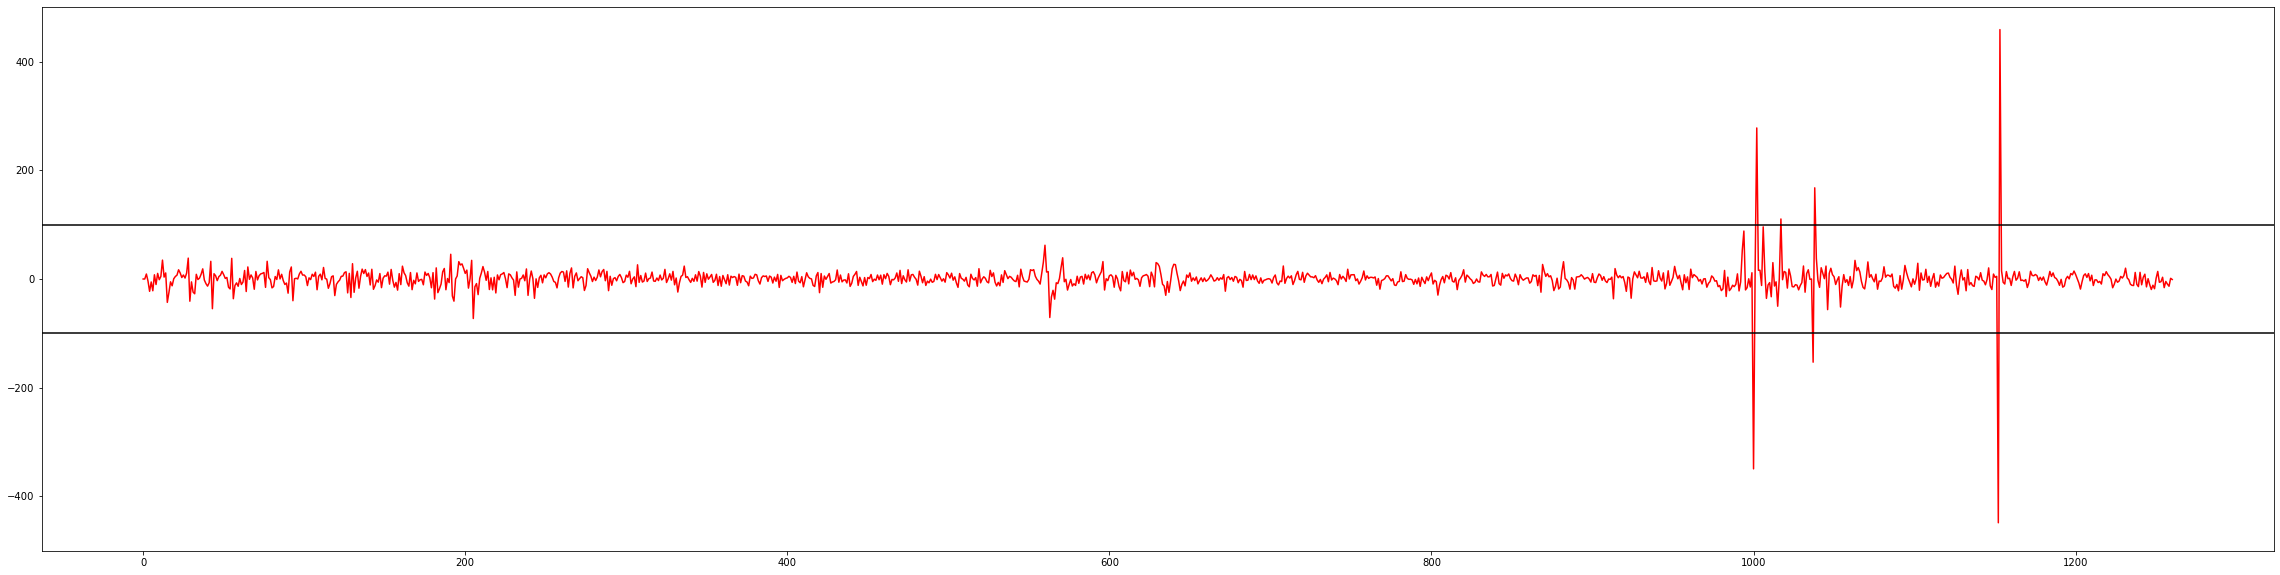

In [16]:
detect = [0]
for i in range(1, len(fits_list)):
    detect.append(fits_list[i][1][2] - fits_list[i - 1][1][2])
plt.plot(detect, color="r")
plt.axhline(y=100, color="k")
plt.axhline(y=-100, color="k")
plt.ylim([-500, 500])
plt.savefig("output_images/outliers1.pdf")

Improving the method to remove these outliers:

In [17]:
def draw_lanes(image, cal, frame, last_fits):
    """Function to annotate lane lines to a given image.

    Using all steps of pipeline above.

    Parameters:
        image (np.array) : Input image.
        cal (dict) : Camera calibration dictionary.
    Returns:
        image (np.array) : Output annotaed image.
    """

    # Applying each stange of the pipline in turn
    undst = distortion_correction(cal, image)
    source = np.float32([[80, 650], [540, 460], [740, 460], [1200, 650]])
    destination = np.float32([[20, 700], [20, 20], [1260, 20], [1260, 700]])
    warped, M, Minv = perspective_transform(undst, source, destination)
    gradx = gradient_thresholding(warped, orient="x", sobel_kernel=3, thresh=(20, 255))
    grady = gradient_thresholding(warped, orient="y", sobel_kernel=3, thresh=(250, 255))
    mag = gradient_thresholding(warped, orient="mag", sobel_kernel=3, thresh=(250, 255))
    dirr = gradient_thresholding(
        warped, orient="dir", sobel_kernel=3, thresh=(0.2, 0.4)
    )
    grad_thresh = np.zeros_like(dirr)
    grad_thresh[(gradx == 1) | (grady == 1) | (mag == 1) | (dirr == 1)] = 1
    color0 = color_thresholding(warped, channel=0, thresh=(20, 100))
    color1 = color_thresholding(warped, channel=1, thresh=(210, 255))
    color2 = color_thresholding(warped, channel=2, thresh=(140, 255))
    color_thresh = np.zeros_like(color0)
    color_thresh[(grad_thresh == 1) | (color0 == 1) | (color1 == 1) | (color2 == 1)] = 1
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        color_thresh, nwindows=15, margin=70, minpix=20
    )
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(
        color_thresh, leftx, lefty, rightx, righty
    )

    # Fall back to previous frame if this frame is spurious.
    fits = (left_fit, right_fit, left_fitx, right_fitx, ploty)
    if frame > 0:
        if abs(last_fits[1][2] - fits[1][2]) > 100:
            print(
                "spurious frame detected at frame = {0}, rolling back to last frame.".format(
                    frame
                )
            )
            fits = copy.deepcopy(last_fits)
    (left_fit, right_fit, left_fitx, right_fitx, ploty) = fits
    (
        left_position,
        right_position,
        left_curverad,
        right_curverad,
    ) = measure_position_curvature(color_thresh, fits[0], fits[1], ploty)

    # Draw the region of lanes identified onto the undistorted image and return
    warp_zero = np.zeros_like(color_thresh).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    return result, fits

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


cal = calibrate_camera(glob.glob("camera_cal/calibration*.jpg"), size=(9, 6))


def process_image(image):
    global fits, fits_list, frame
    frame += 1
    result, fits = draw_lanes(image, cal, frame, fits)
    fits_list.append(fits)
    return result


fits = None
fits_list = []
frame = -1


output1 = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output1, audio=False)

t:   0%|          | 2/1260 [00:00<01:34, 13.28it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



t:  80%|███████▉  | 1002/1260 [01:57<00:30,  8.52it/s, now=None]

spurious frame detected at frame = 1000, rolling back to last frame.
spurious frame detected at frame = 1001, rolling back to last frame.


t:  81%|████████  | 1019/1260 [01:59<00:27,  8.91it/s, now=None]

spurious frame detected at frame = 1017, rolling back to last frame.
spurious frame detected at frame = 1018, rolling back to last frame.


t:  81%|████████  | 1021/1260 [01:59<00:26,  8.96it/s, now=None]

spurious frame detected at frame = 1019, rolling back to last frame.
spurious frame detected at frame = 1020, rolling back to last frame.


t:  81%|████████  | 1023/1260 [02:00<00:29,  8.07it/s, now=None]

spurious frame detected at frame = 1021, rolling back to last frame.
spurious frame detected at frame = 1022, rolling back to last frame.


t:  81%|████████▏ | 1025/1260 [02:00<00:30,  7.70it/s, now=None]

spurious frame detected at frame = 1023, rolling back to last frame.
spurious frame detected at frame = 1024, rolling back to last frame.


t:  82%|████████▏ | 1027/1260 [02:00<00:28,  8.19it/s, now=None]

spurious frame detected at frame = 1025, rolling back to last frame.
spurious frame detected at frame = 1026, rolling back to last frame.


t:  82%|████████▏ | 1039/1260 [02:02<00:26,  8.37it/s, now=None]

spurious frame detected at frame = 1037, rolling back to last frame.


t:  92%|█████████▏| 1153/1260 [02:14<00:12,  8.59it/s, now=None]

spurious frame detected at frame = 1152, rolling back to last frame.


Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 7min 19s, sys: 1min 21s, total: 8min 40s
Wall time: 2min 27s


Now the outliers are removed:

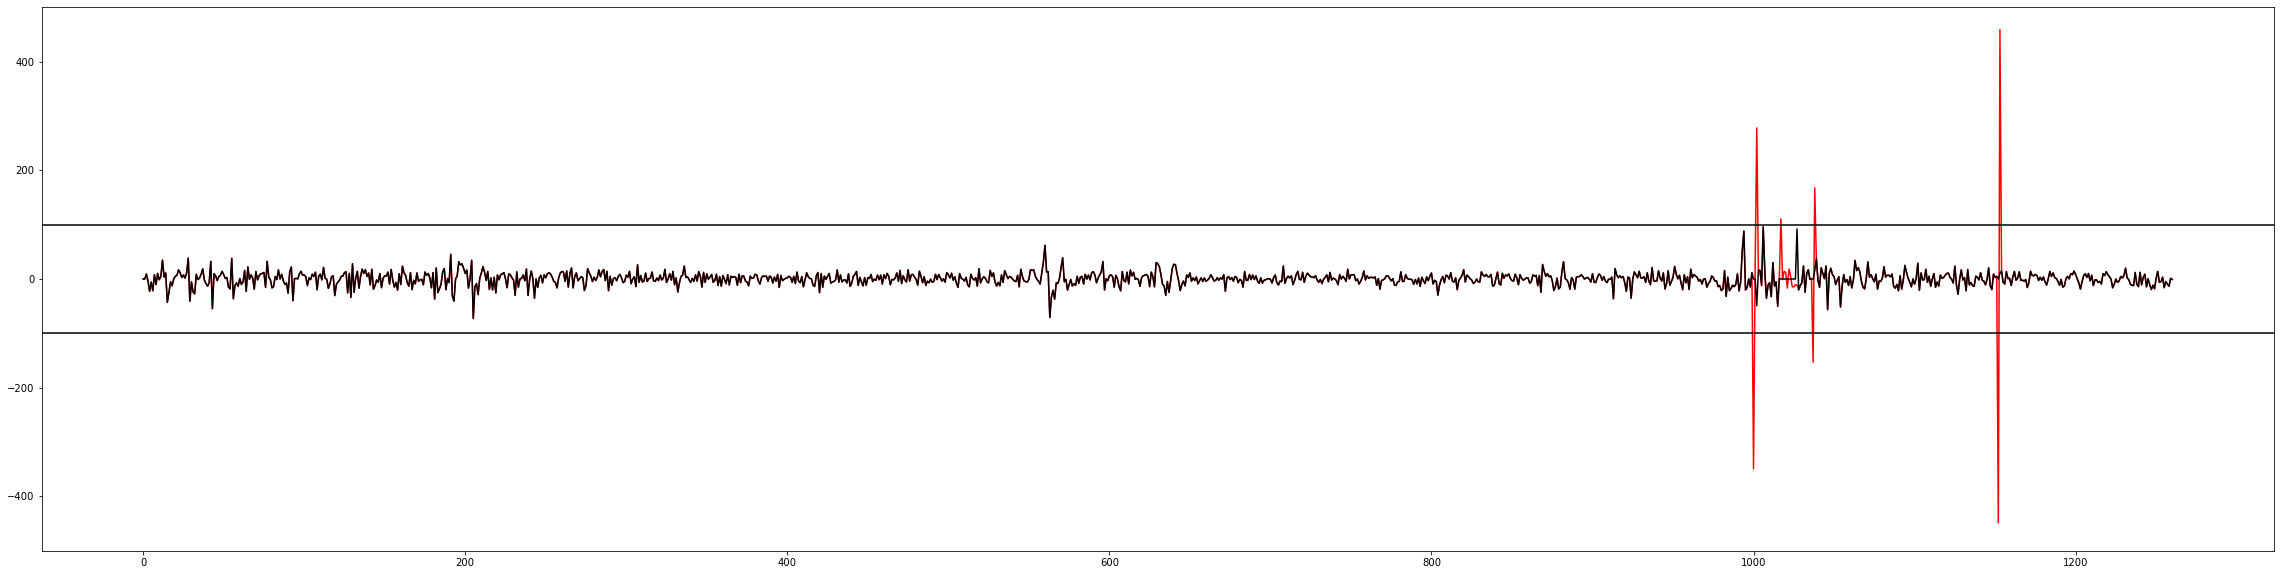

In [19]:
detect2 = [0]
for i in range(1, len(fits_list)):
    detect2.append(fits_list[i][1][2] - fits_list[i - 1][1][2])
plt.plot(detect, color="r")
plt.plot(detect2, color="k")
plt.axhline(y=100, color="k")
plt.axhline(y=-100, color="k")
plt.ylim([-500, 500])
plt.savefig("output_images/outliers2.pdf")

In [20]:
HTML(
    """<video width="960" height="540" controls>  <source src="{0}"></video>""".format(
        output1
    )
)